In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Package installation (hidden on docs website).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)

dependencies = ["cleanlab", "matplotlib", "torch", "torchvision", "skorch"]

# install each dependency
for dep in dependencies:
    !pip install {dep}
    

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 10.7 MB/s eta 0:00:00


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt 
import os
from PIL import Image
import torch
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
#from keras.preprocessing.image import load_img
from keras.utils import np_utils
#from tensorflow.python.keras.layers import Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Activation,Dropout, Dense
from tensorflow.keras.layers import BatchNormalization, Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Activation,Dropout, Dense
#from tensorflow.python.keras import Sequential,backend,optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from tensorflow.keras import optimizers
import warnings

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [4]:
data = []
labels = []
parasite_data = os.listdir('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/')
uninfected_data = os.listdir('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/')

for img in parasite_data:
    try:
        img_file = plt.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/' + img)
        img_resize = cv2.resize(img_file, (50,50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None
        

for img in uninfected_data:
    try:
        img_file = plt.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/' + img)
        img_resize = cv2.resize(img_file, (50,50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

image_data = np.array(data)
labels = np.array(labels)
print("image_data:",len(image_data))
print("labels:",len(labels))

image_data: 27558
labels: 27558


Parasitized Sample:



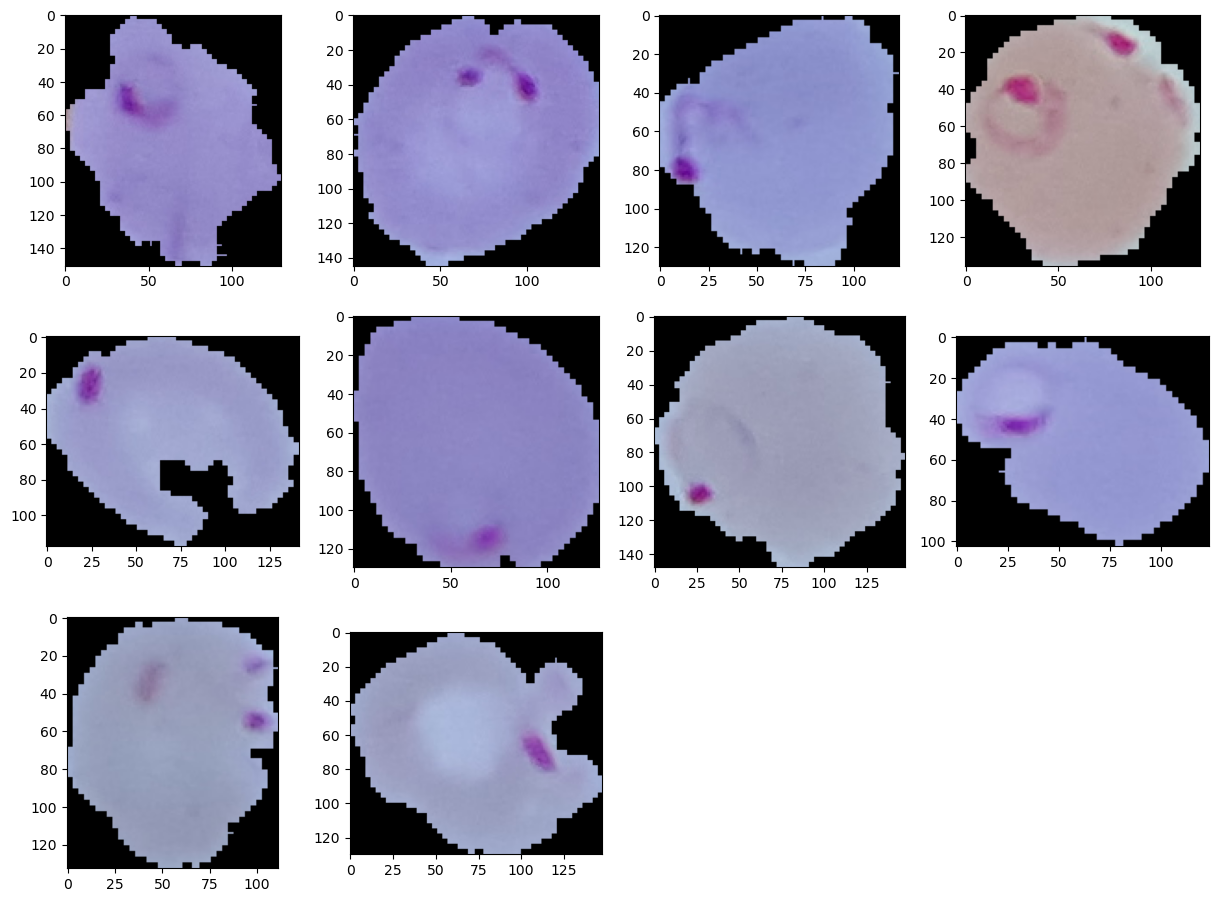

Uninfected Sample:



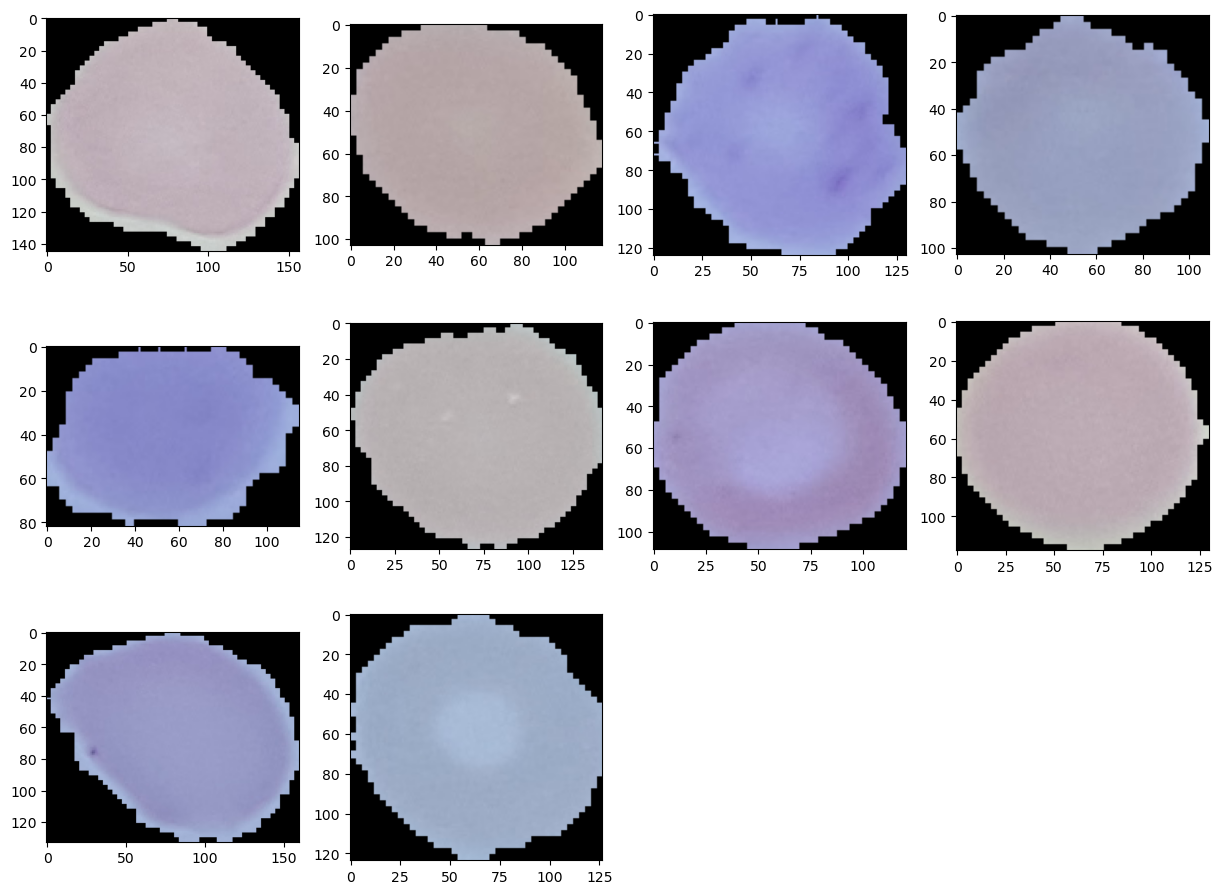

In [5]:
print("Parasitized Sample:\n")
plt.figure(figsize = (15,15))
for i in range(10):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/' + parasite_data[i])
    plt.imshow(img)
plt.show()

print("Uninfected Sample:\n")
plt.figure(figsize = (15,15))
for i in range(10):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/'+ uninfected_data[i])
    plt.imshow(img)
plt.show()

In [6]:
print(image_data.shape)
# # print sample image_data
# print(image_data[2000])
# print(labels)

X= image_data
y=labels

(27558, 50, 50, 3)


In [7]:
y = np_utils.to_categorical(y, num_classes = 2)
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_predict

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()

        input_shape = (50, 50, 3)

        if backend.image_data_format() == 'channels_first':
            input_shape = (3, 50, 50)
        inputs = Input(shape=input_shape)
        x = Conv2D(32, (3,3), activation='relu')(inputs)
        x = MaxPooling2D(2,2)(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(0.2)(x)

        x = Conv2D(32, (3,3), activation='relu')(x)
        x = MaxPooling2D(2,2)(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(0.2)(x)

        x = Conv2D(32, (3,3), activation='relu')(x)
        x = MaxPooling2D(2,2)(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(0.2)(x)

        x = Flatten()(x)

        x = Dense(512, activation='relu')(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(0.5)(x)
        outputs = Dense(2, activation='softmax')(x)

        self.model = Model(inputs=inputs, outputs=outputs)

        # compile the model and define the loss function
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

def create_model():
    return MyModel().model

estimator = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)
num_crossval_folds = 3
pred_probs = cross_val_predict(
    estimator,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba"
)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/10


2023-04-23 19:23:07.896671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


575/575 [==============================] - 12s 7ms/step - loss: 0.5145 - accuracy: 0.7888
Epoch 2/10
575/575 [==============================] - 3s 6ms/step - loss: 0.2058 - accuracy: 0.9342
Epoch 3/10
575/575 [==============================] - 4s 6ms/step - loss: 0.1655 - accuracy: 0.9487
Epoch 4/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1470 - accuracy: 0.9546
Epoch 5/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1477 - accuracy: 0.9554
Epoch 6/10
575/575 [==============================] - 4s 6ms/step - loss: 0.1309 - accuracy: 0.9602
Epoch 7/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1297 - accuracy: 0.9586
Epoch 8/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1237 - accuracy: 0.9617
Epoch 9/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1236 - accuracy: 0.9621
Epoch 10/10
288/288 [==============================] - 1s 2ms/step
Epoch 1/10


2023-04-23 19:24:34.370009: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


575/575 [==============================] - 6s 6ms/step - loss: 0.4681 - accuracy: 0.8066
Epoch 2/10
575/575 [==============================] - 4s 6ms/step - loss: 0.2076 - accuracy: 0.9278
Epoch 3/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1809 - accuracy: 0.9406
Epoch 4/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1686 - accuracy: 0.9442
Epoch 5/10
575/575 [==============================] - 4s 7ms/step - loss: 0.1623 - accuracy: 0.9468
Epoch 6/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1626 - accuracy: 0.9491
Epoch 7/10
575/575 [==============================] - 4s 6ms/step - loss: 0.1558 - accuracy: 0.9488
Epoch 8/10
575/575 [==============================] - 4s 7ms/step - loss: 0.1526 - accuracy: 0.9501
Epoch 9/10
575/575 [==============================] - 4s 6ms/step - loss: 0.1484 - accuracy: 0.9524
Epoch 10/10
288/288 [==============================] - 1s 2ms/step
Epoch 1/10


2023-04-23 19:25:15.764972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


575/575 [==============================] - 6s 6ms/step - loss: 0.4591 - accuracy: 0.8029
Epoch 2/10
575/575 [==============================] - 4s 7ms/step - loss: 0.2061 - accuracy: 0.9181
Epoch 3/10
575/575 [==============================] - 4s 6ms/step - loss: 0.1595 - accuracy: 0.9381
Epoch 4/10
575/575 [==============================] - 4s 6ms/step - loss: 0.1551 - accuracy: 0.9412
Epoch 5/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1425 - accuracy: 0.9460
Epoch 6/10
575/575 [==============================] - 4s 6ms/step - loss: 0.1335 - accuracy: 0.9501
Epoch 7/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1318 - accuracy: 0.9497
Epoch 8/10
575/575 [==============================] - 3s 6ms/step - loss: 0.1298 - accuracy: 0.9505
Epoch 9/10
575/575 [==============================] - 4s 6ms/step - loss: 0.1225 - accuracy: 0.9548
Epoch 10/10
288/288 [==============================] - 1s 2ms/step


In [9]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
true_labels = y.argmax(axis=1)
acc = accuracy_score(true_labels, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.9080847666739241


In [10]:
len(pred_probs)

27558

In [11]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    y.argmax(axis=1),
    pred_probs,
    return_indices_ranked_by="self_confidence",
)
print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Top 15 most likely label errors: \n {ranked_label_issues[:15]}")


Cleanlab found 1650 label issues.
Top 15 most likely label errors: 
 [26788 26867 18559 21044 18802 25170 27434 23697 20948 24619 20970 26799
 21813 22825 26060]


In [12]:
y=np.argmax(y, axis=1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_examples(id_iter, nrows=1, ncols=1):
    plt.figure(figsize=(8,8))
    for count, id in enumerate(id_iter):
        img = np.transpose(X[id], (1, 0, 2))  # Transpose the axes of the image data
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(img)
        plt.title(f"id: {id} \n label: {y[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)


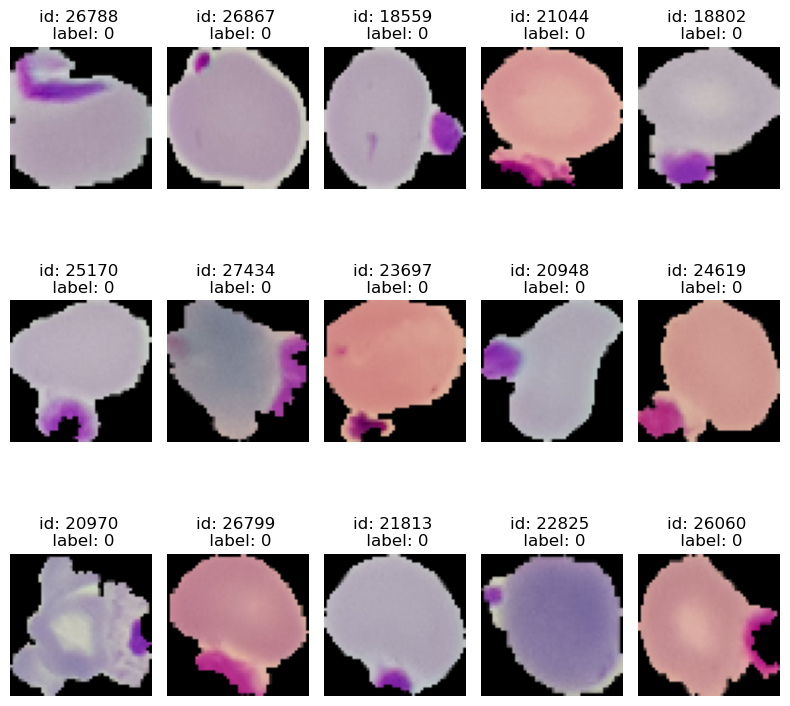

In [14]:
plot_examples(ranked_label_issues[range(15)], 3, 5)

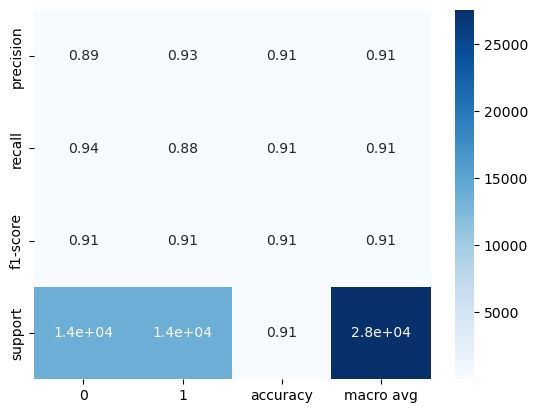

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

predicted_labels = pred_probs.argmax(axis=1)
report = classification_report(y, predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
sns.heatmap(df.iloc[:-1, :].T, annot=True, cmap='Blues')
plt.show()

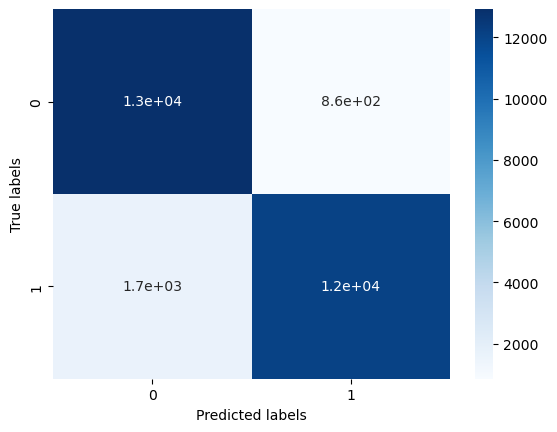

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_labels = pred_probs.argmax(axis=1)
cm = confusion_matrix(y, predicted_labels)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [17]:
# Get indices of correctly labeled examples
correct_indices = np.setdiff1d(np.arange(len(y)), ranked_label_issues)
# Filter out incorrectly labeled examples
X_clean = X[correct_indices]
y_clean = y[correct_indices]



print(X_clean.shape)
print(y_clean.shape)

(25908, 50, 50, 3)
(25908,)


In [18]:
import cv2
import os

# Create directories for saving the images
os.makedirs("clean/parasitized", exist_ok=True)
os.makedirs("clean/uninfected", exist_ok=True)

# Save the clean images based on their labels
for i in range(X_clean.shape[0]):
    if y_clean[i] == 1:
        cv2.imwrite(f"clean/parasitized/{i}.png", X_clean[i])
    else:
        cv2.imwrite(f"clean/uninfected/{i}.png", X_clean[i])
